# Vehicle Detection Project
By Pablo Sauras Perez

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector.
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

In [132]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import os
import time
import random
import pickle
import collections
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.cross_validation import train_test_split
from scipy.ndimage.measurements import label
%matplotlib inline

## Data preparation

Read vehicle and non-vehicle datasets

I need to:

* Divide images into vehicle / non-vehicle
* Have a BALANCED DATASET
* RANDOM SHUFFLE the data
* SPLIT the data in training and testing set

In [133]:
#Divide images into vehicle / non-vehicle


cars = []
cars_distr = []
notcars = []
notcars_distr = []

#Car images
directory_cars = "vehicles/"
subdirectory_cars = glob.glob(os.path.join(directory_cars, '*'))

print("Vehicle Images Folders")
print(subdirectory_cars)

for car_subdir in subdirectory_cars:
    images_cars = glob.glob(os.path.join(car_subdir, '*.png'))
    cars.extend(images_cars)
    cars_distr.append([car_subdir, len(images_cars)])

print("Car directory image distribution: " , cars_distr)
print("Number of car images: ", len(cars))
print()

#Not Car images
directory_notcars = "non-vehicles/"
subdirectory_notcars = glob.glob(os.path.join(directory_notcars, '*'))

print("Non-Vehicle Images Folders")
print(subdirectory_notcars)

for notcar_subdir in subdirectory_notcars:
    images_notcars = glob.glob(os.path.join(notcar_subdir, '*.png'))
    notcars.extend(images_notcars)
    notcars_distr.append([notcar_subdir, len(images_notcars)])

print("Number of NOT car images: ", len(notcars))
print("NOT Car directory image distribution: " , notcars_distr)

Vehicle Images Folders
['vehicles/GTI_Far', 'vehicles/GTI_MiddleClose', 'vehicles/KITTI_extracted', 'vehicles/GTI_Left', 'vehicles/GTI_Right']
Car directory image distribution:  [['vehicles/GTI_Far', 834], ['vehicles/GTI_MiddleClose', 419], ['vehicles/KITTI_extracted', 5966], ['vehicles/GTI_Left', 909], ['vehicles/GTI_Right', 664]]
Number of car images:  8792

Non-Vehicle Images Folders
['non-vehicles/GTI', 'non-vehicles/Extras']
Number of NOT car images:  8968
NOT Car directory image distribution:  [['non-vehicles/GTI', 3900], ['non-vehicles/Extras', 5068]]


## Data Exploration

Function to explore the data that was just loaded (based on lesson code)

In [134]:
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    
    # Read in a test image, either car or notcar
    img = cv2.imread(car_list[0])
    
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = img.shape
    
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = img.dtype
    
    # Return data_dict
    return data_dict

Explore the dataset and plot one vehicle image and one non-vehicle image

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: uint8


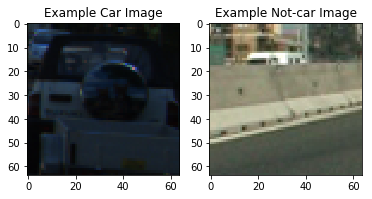

In [135]:
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')
plt.savefig('output_images/CarNoCarExample.jpg')

## Get HOG features

Define a function to return HOG features and visualization

In [136]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, feature_vector=feature_vec)
        
        return features

Try HOG features extraction

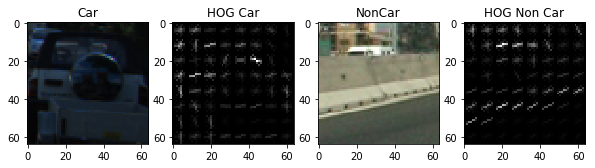

In [204]:
car_conv = cv2.cvtColor(car_image, cv2.COLOR_RGB2GRAY)
notcar_conv = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2GRAY)

orient = 9
pix_per_cell = 8
cell_per_block = 2

# Call our function with vis=True to see an image output
features_car, hog_image_car = get_hog_features(car_conv, orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)

features_notcar, hog_image_notcar = get_hog_features(notcar_conv, orient, 
                        pix_per_cell, cell_per_block, 
                       vis=True, feature_vec=True)


# Plot the examples
fig = plt.figure(figsize = (10, 10))
plt.subplot(141)
plt.imshow(car_image, cmap='gray')
plt.title('Car')
plt.subplot(142)
plt.imshow(hog_image_car, cmap='gray')
plt.title('HOG Car')

plt.subplot(143)
plt.imshow(notcar_image, cmap='gray')
plt.title('NonCar')
plt.subplot(144)
plt.imshow(hog_image_notcar, cmap='gray')
plt.title('HOG Non Car')
plt.savefig('output_images/HOGCarNoCarExample.jpg')


Function to convert to colorspaces

In [138]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

## Get bin spatial and color histogram

In [139]:
def bin_spatial(img, size=(32, 32)):
    color1 = cv2.resize(img[:,:,0], size).ravel()
    color2 = cv2.resize(img[:,:,1], size).ravel()
    color3 = cv2.resize(img[:,:,2], size).ravel()
    return np.hstack((color1, color2, color3))


# Define a function to compute color histogram features  
def color_hist(img, nbins=32):# , bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)# , range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)# , range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)# , range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

## Function to extract features a list of images

Can extract: spatial bin, color histogram and HOG

In [141]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, cspace='RGB',  spatial_size=(32, 32), hist_bins=32, orient=9, 
                    pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_feat=False, 
                    hist_feat=False, hog_feat=False, fig_title=('Car', 'HOG Car')):
    # Create a list to append feature vectors to
    features = []
    feature_image = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)  
            
        # Apply bin_spatial() to get spatial color features
        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, spatial_size)
            #Append to feature list
            file_features.append(spatial_features)
            
        
        # Apply color_hist() to get color histogram features
        if hist_feat == True:
            hist_features = color_hist(feature_image, nbins=hist_bins)
            #Append to feature list
            file_features.append(hist_features)

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_feat == True:
            if hog_channel == 'ALL':
                hog_features = []
                hog_images = []
                for channel in range(feature_image.shape[2]):
                    hog_fet, hog_img = get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=True, feature_vec=True)
                    hog_features.extend(hog_fet)
                    hog_images.append(hog_img)
                    #hog_features.append(get_hog_features(feature_image[:,:,channel], 
                    #                    orient, pix_per_cell, cell_per_block, 
                    #                    vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features, hog_images = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            
                #hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                #            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
        
        
    
    fig = plt.figure(figsize = (10, 10))
    plt.subplot(151)
    plt.imshow(image)
    plt.title(fig_title[0])
    plt.subplot(152)
    plt.imshow(feature_image[:,:,0], cmap='gray')
    plt.title(fig_title[0] + ' ' + cspace[0])
    plt.subplot(153)
    plt.imshow(feature_image[:,:,1], cmap='gray')
    plt.title(fig_title[0] + ' ' + cspace[1])
    plt.subplot(154)
    plt.imshow(feature_image[:,:,2], cmap='gray')
    plt.title(fig_title[0] + ' ' + cspace[2])
    plt.subplot(155)
    if hog_channel == 'ALL':
        plt.imshow(hog_images[0], cmap='gray')
        plt.title(fig_title[1])
    else:
        plt.imshow(hog_images, cmap='gray')
        plt.title(fig_title[1])
        #feature_image.append(hog_images)
        #features.append(np.concatenate((col_features, hist_features, hog_features)))
    plt.savefig('output_images/' + fig_title[0] + 'FeaturesExample.jpg')
    # Return list of feature vectors
    print("Spatial: ", spatial_feat, " Color Hist: ", hist_feat, " HOG: ", hog_feat)
    return features


## Extract features from list of images

I work here with 2000 images to speed things up. I select random vehicle and non-vehicle images (from the ones previously loaded).

Then I tweak the parameters to extract the features.

Spatial:  True  Color Hist:  True  HOG:  True
Spatial:  True  Color Hist:  True  HOG:  True
177.5 Seconds to extract HOG features...


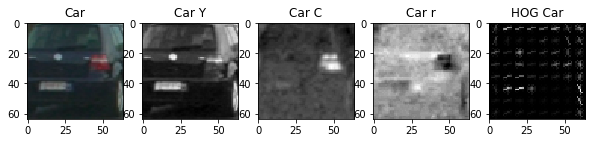

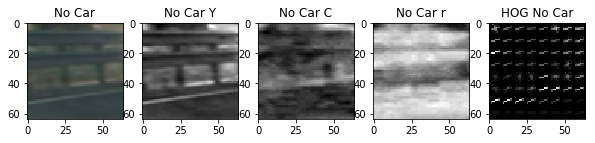

In [161]:
# Reduce the sample size because HOG features are slow to compute
# The quiz evaluator times out after 13s of CPU time
sample_size = 2000
#cars = cars[0:sample_size]
#notcars = notcars[0:sample_size]
cars_sample = random.sample(cars, sample_size)
notcars_sample = random.sample(notcars, sample_size)

### TODO: Tweak these parameters and see how the results change.
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9 # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off


t=time.time()
car_features = extract_features(cars_sample, cspace=colorspace, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, fig_title=('Car', 'HOG Car'))

notcar_features = extract_features(notcars_sample, cspace=colorspace, spatial_size=spatial_size, hist_bins=hist_bins, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, fig_title=('No Car', 'HOG No Car'))

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

## Train SVM

### Separate Train and Test Sets

Don't forget to normalize the feature vectors

In [164]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)


# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460


### Train using Linear SVM

In [165]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

0.99 Seconds to train SVC...
Test Accuracy of SVC =  0.9912
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  1.]
0.00231 Seconds to predict 10 labels with SVC


## Slidding Window Search

### Read Test Images

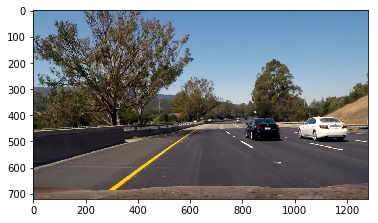

In [191]:
test_file = 'test6.jpg'
test_image = mpimg.imread('test_images/' + test_file)
plt.imshow(test_image)

Function to find cars in an image.
In this case I used HOG-subsampling Window Search

NOTE: Be careful. Train and test must match. If I train only with HOG features, test opnly with HOG. If I train with HOG and color, test with HOG and color... and so on... it is easy to "forget" about it...

In [192]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    bbox_list = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]
    
    

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    

    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

           # print(hog1.shape)
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)
            
           # print(spatial_features.shape)
           # print(hist_features.shape)
            #print(hog_features.shape)
            

            # Scale features and make a prediction
            #NOTE: If I train only hog... I test only hog
            
  
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))     
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
                #Define the box ((x1, y1), (x2, y2))
                x1 = xbox_left
                y1 = ytop_draw+ystart
                x2 = xbox_left+win_draw
                y2 = ytop_draw+win_draw+ystart
                
                bbox_list.append(((x1,y1),(x2,y2)))
                
    return draw_img, bbox_list

## Test vehicle detection on test images

First just detection from window search...

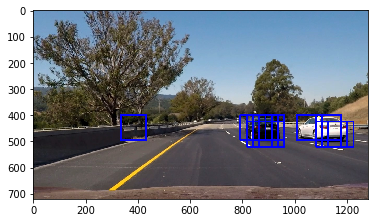

In [193]:
ystart = 400
ystop = 656
scale = 1.5
    
out_img, box_list = find_cars(test_image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

plt.imshow(out_img)


## Heatmap generation

In [194]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

Now.... remove false positives with heatmap generation

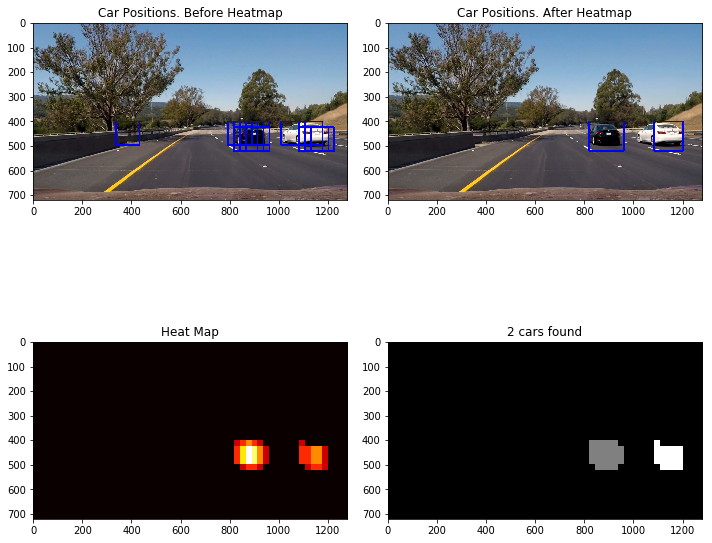

In [195]:
heat = np.zeros_like(test_image[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat,box_list)
    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,1)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_image), labels)

fig = plt.figure(figsize = (10, 10))
plt.subplot(221)
plt.imshow(out_img)
plt.title('Car Positions. Before Heatmap')
plt.subplot(222)
plt.imshow(draw_img)
plt.title('Car Positions. After Heatmap')
plt.subplot(223)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
plt.subplot(224)
plt.imshow(labels[0], cmap='gray')
plt.title(str(labels[1]) +  ' cars found')
fig.tight_layout()
plt.savefig('output_images/' + test_file + 'HeatmapExample.jpg')

Save parameters in pickle file

In [196]:
dist_pickle = {}
dist_pickle["svc"] = svc
dist_pickle["scaler"] = X_scaler
dist_pickle["orient"] = orient
dist_pickle["pix_per_cell"] = pix_per_cell
dist_pickle["cell_per_block"] = cell_per_block
dist_pickle["spatial_size"] = spatial_size
dist_pickle["hist_bins"] = hist_bins
dist_pickle["y_start"] = ystart
dist_pickle["y_stop"] = ystop
dist_pickle["scale"] = scale
pickle.dump( dist_pickle, open( "svc_pickle.p", "wb" ) )

# Video

Now I test vehicle detection in video

In [197]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Process Function. Every frame of the video goes to this function (which has the pipeline steps)
I use collections to smooth the detection of vehicles taking into account several video frames.


In [205]:
heatmaps = collections.deque(maxlen=20) 
# 1. Read pickle file
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]
ystart = dist_pickle["y_start"]
ystop = dist_pickle["y_stop"]
scale = dist_pickle["scale"]

def process_image(image):

    out_img, box_list = find_cars(image, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)
    
    #Append to heatmap collection and sum them
    heatmaps.append(heat)
    heatmap_sum = sum(heatmaps)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heatmap_sum,1)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
                        
    return draw_img                   

In [206]:
output_clip = "project_video_result.mp4"
clip = VideoFileClip("project_video.mp4")

clip_result = clip.fl_image(process_image)

%time clip_result.write_videofile(output_clip, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4


100%|█████████▉| 1260/1261 [08:12<00:00,  2.59it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 13min 53s, sys: 1.83 s, total: 13min 55s
Wall time: 8min 12s


In [129]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_clip))